In [126]:
import numpy as np
import matplotlib.pyplot as plt
import pyart

In [127]:
def rca_cluttermap_function(filename):
    '''Creates a clutter map (precip-free day) to be used for the RCA calculation for PPIs'''
    radar = pyart.io.cfradial.read_cfradial(filename)
    date_time = radar.time['units'].replace('seconds since ', '')
    
    # Constrain range between 1 - 5 km
    r_start_idx = np.where(radar.range['data'] < 1000.)[0][-1]+1
    r_start_idx = 0
    r_stop_idx = np.where(radar.range['data'] > 5000.)[0][0]
    
    # Using lowest elevation angle of PPI (0.5 deg)
    sweep_start_idx = radar.sweep_start_ray_index['data'][0]
    sweep_stop_idx = radar.sweep_end_ray_index['data'][0]+1
    
    # Get variables (only the rays/gates needed)
    zh = radar.fields['reflectivity']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    zdr = radar.fields['differential_reflectivity']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    r = radar.range['data'][r_start_idx:r_stop_idx]
    theta = radar.azimuth['data'][sweep_start_idx:sweep_stop_idx]
    
    # Eliminate duplicate azimuths to maintain a total # of azimuths of 360
    if len(theta) > 360:
        diff = len(theta) - 360
        zh = np.delete(zh,-diff,axis=0)
        theta = np.delete(theta,-diff)
        
    # Arrange/sort azimuths to span 0 to 360 deg. from index 0 to 359
    sorted_idx = np.argsort(theta)
    zh = zh[sorted_idx,:]
    theta = theta[sorted_idx]
    
    # Create a fixed polar grid/array (FPG; 1 deg x 1 km) and create mask to flag clutter
    r_grid = np.array((0,1,2,3,4,5))*1000.
    theta_grid = theta
    r_matrix, theta_matrix = np.meshgrid(r_grid,theta_grid)
    clutter_flag = np.zeros((r_matrix.shape))
    
    # Set reflectivity threshold 55 dBZ
    # Flag PPI pixels in FPG box that exceed threshold
    z_thresh = 45.
    
    # Create an empty array to fill with Z from the clutter area reflectivity grid boxes (CAR)
    zh_car = np.empty((zh.shape))
    zh_car[:,:] = np.nan

    for i in range(0,len(theta_matrix[:,0])):
        for j in range(0,len(r_matrix[0,:])):
            if j == 0:
                clutter_flag[:,0] = np.nan
            else:
                if np.logical_or(zh[i,j*10-10] >= z_thresh, zh[i,j*10-9] >= z_thresh):
                    clutter_flag[i,j] = 1
                    zh_car[i,j*10-10:j*10-1] = zh[i,j*10-10:j*10-1]
                elif np.logical_or(zh[i,j*10-8] >= z_thresh, zh[i,j*10-7] >= z_thresh):
                    clutter_flag[i,j] = 1
                    zh_car[i,j*10-10:j*10-1] = zh[i,j*10-10:j*10-1]
                elif np.logical_or(zh[i,j*10-6] >= z_thresh, zh[i,j*10-5] >= z_thresh):
                    clutter_flag[i,j] = 1
                    zh_car[i,j*10-10:j*10-1] = zh[i,j*10-10:j*10-1]
                elif np.logical_or(zh[i,j*10-4] >= z_thresh, zh[i,j*10-3] >= z_thresh):
                    clutter_flag[i,j] = 1
                    zh_car[i,j*10-10:j*10-1] = zh[i,j*10-10:j*10-1]
                elif np.logical_or(zh[i,j*10-2] >= z_thresh, zh[i,j*10-1] >= z_thresh):
                    clutter_flag[i,j] = 1
                    zh_car[i,j*10-10:j*10-1] = zh[i,j*10-10:j*10-1]
                else:
                    clutter_flag[i,j] = 0
                    
    # Calculate the PDF of the clutter area reflectivity (CAR)
    mask = np.where(np.isfinite(zh_car))  
    n,bins,patches=plt.hist(zh_car[mask],bins=105,range=(-40.,65.))
    
    # Calculate CDF of clutter area reflectivity
    cdf = np.cumsum(n)
    p = cdf/cdf[-1]*100
    
    x = np.arange(105)-40
    coeff = np.polyfit(p,x,10) # Find coefficients of 10th degree polynomial for CDF
    poly_func = np.poly1d(coeff)
    #x_poly = np.linspace(p[0],p[-1],105)
    #y_poly = poly_func(x_poly)
    
    # Find the value of reflectivity at the 95th percentile of CDF
    dbz95 = poly_func(95.)
    
    del radar
    return clutter_flag, r_matrix, theta_matrix, zh, zh_car, date_time, n, bins, p, dbz95

/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181102.231504.nc


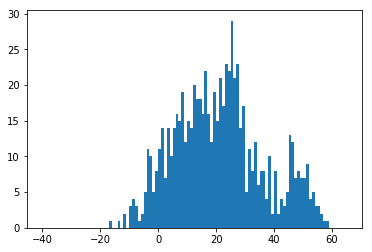

In [128]:
# Run this function on a bunch of files (try data from one day)
import os
import glob
import scipy.stats as stats
from scipy.stats import norm 

clutter_flag = []
theta = []
r = []
zh = []
zhCAR = []
dt = []
n = []
bins = []
cdf = []
p = []
dbz95 = []



for f in glob.glob(os.path.join('/home/hunzinger/data/ppi_cf/', 'corcsapr2cfrppi*.20181102.2315*.nc')):
    print(f)
    ClutterFlag, R, Theta, ZH, ZHCAR, DateTime, N, Bins, P, DBZ95 = rca_cluttermap_function(f)
    
    # Put all PPI times into a list
    clutter_flag.append(ClutterFlag)
    r.append(R)
    theta.append(Theta)
    zh.append(ZH)
    zhCAR.append(ZHCAR)
    dt.append(DateTime)
    n.append(N)
    bins.append(Bins)
    p.append(P)
    dbz95.append(DBZ95)


(1, 360, 6)
(360, 6)


/home/hunzinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


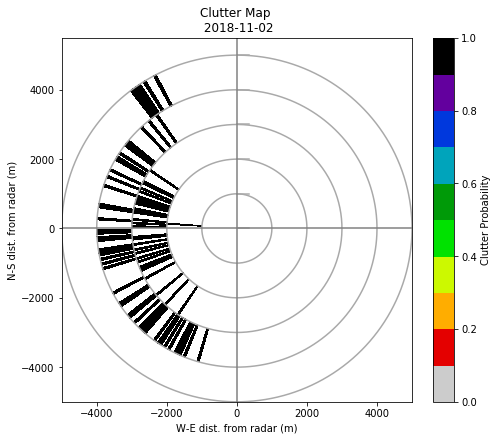

In [129]:
clutter_flag = np.asarray(clutter_flag)
print(clutter_flag.shape)
PCT_on = np.sum(clutter_flag,axis=0)/len(clutter_flag[:,0,0])

# Mask values less than 0.5
mask_u50 = np.where(PCT_on <= 0.5)
PCT_on_50 = np.copy(PCT_on)
PCT_on_50[mask_u50] = np.nan
print(PCT_on_50.shape)

# Plot clutter map
from matplotlib.colors import BoundaryNorm
# Convert to cartesian coords to plot
x = (r[0]*np.sin(theta[0]*np.pi/180.))
y = (r[0]*np.cos(theta[0]*np.pi/180.))
#levels = np.arange(6)/10+0.5
levels = np.arange(11)/10
# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('nipy_spectral_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax1 = plt.subplots(figsize=[6.8,6],constrained_layout=True)
ax1.plot(x,y,(x**2+y**2)**(0.5),color='darkgrey')
ax1.axvline(0,-5000,5000,color='grey')
ax1.axhline(0,-5000,5000,color='grey')
im = ax1.pcolormesh(x, y, PCT_on_50, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax1)
cbar.ax.set_ylabel('Clutter Probability')
ax1.set_title('Clutter Map \n 2018-11-02')
ax1.set_xlabel('W-E dist. from radar (m)')
ax1.set_ylabel('N-S dist. from radar (m)')

plt.show()

(1, 360, 51) (1, 360, 51) (360, 6)
1 1
49.541238247840845


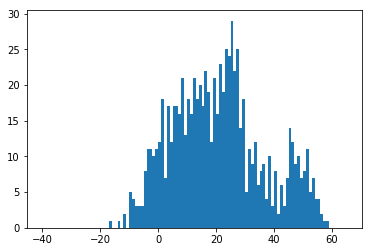

dBZ95 baseline = 49.541238247840845
49.21285998656316


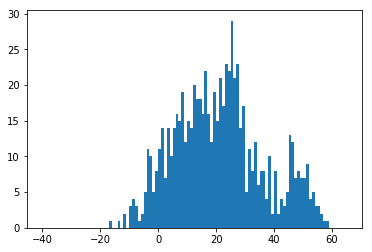

dBZ95 baseline CAR = 49.21285998656316
(360, 51)
(360, 51)


In [130]:
# Want to calculate the PDF and CDf and get 95th percentile reflectivity
# Only use reflecitivity that falls within the PCT_on_50 grid boxes

#zh_mean = np.nanmean(zh,axis=0)
#Fill a z array for the PCT_on_50 boxes
zh = np.asarray(zh)
zhCAR = np.asarray(zhCAR)
zh_50 = np.empty((zh.shape))
zhCAR_50 = np.empty((zhCAR.shape))
zh_50[:,:,:] = np.nan
zhCAR_50[:,:,:] = np.nan
print(zh_50.shape, zhCAR_50.shape, PCT_on_50.shape)
print(len(zh[:,0,0]), len(zhCAR[:,0,0]))
#print(np.isfinite(PCT_on_50))

for k in range(0, len(zh[:,0,0])):
    for i in range(0,len(PCT_on_50[:,0])):
        for j in range(0,len(PCT_on_50[0,:])):
            if np.isfinite(PCT_on_50[i,j]):
                zh_50[k,i,j*10-10:j*10] = zh[k,i,j*10-10:j*10]

dbz95_baseline = []
for k in range(0, len(zh[:,0,0])):            
    maskk = np.where(np.isfinite(zh_50[k,:,:])) 
    n,bins,patches=plt.hist(zh_50[k,:,:][maskk],bins=105,range=(-40.,65.))
    cdf = np.cumsum(n)
    p_mean = cdf/cdf[-1]*100
    x = np.arange(105)-40
    coeff = np.polyfit(p_mean,x,13) # Find coefficients of 10th degree polynomial for CDF
    poly_func = np.poly1d(coeff)
    dbz95 = poly_func(95.)
    dbz95_baseline.append(dbz95)
    print(dbz95)
plt.show()

dbz95_baseline_mean = np.nanmean(dbz95_baseline)
print('dBZ95 baseline =',dbz95_baseline_mean)


for k in range(0, len(zhCAR[:,0,0])):
    for i in range(0,len(PCT_on_50[:,0])):
        for j in range(0,len(PCT_on_50[0,:])):
            if np.isfinite(PCT_on_50[i,j]):
                zhCAR_50[k,i,j*10-10:j*10] = zhCAR[k,i,j*10-10:j*10]

dbz95_baselineCAR = []
for k in range(0, len(zhCAR[:,0,0])):            
    maskk = np.where(np.isfinite(zhCAR_50[k,:,:])) 
    n,bins,patches=plt.hist(zhCAR_50[k,:,:][maskk],bins=105,range=(-40.,65.))
    cdf = np.cumsum(n)
    p_mean = cdf/cdf[-1]*100
    x = np.arange(105)-40
    coeff = np.polyfit(p_mean,x,13) # Find coefficients of 10th degree polynomial for CDF
    poly_func = np.poly1d(coeff)
    dbz95CAR = poly_func(95.)
    dbz95_baselineCAR.append(dbz95CAR)
    print(dbz95CAR)
plt.show()

dbz95_baseline_meanCAR = np.nanmean(dbz95_baselineCAR)
print('dBZ95 baseline CAR =',dbz95_baseline_meanCAR)


print(zh[0,:,:].shape)
print(zh[0,:,0:].shape)
#maskk = np.where(np.isfinite(zh_50[0,:,:])) 
#n,bins,patches=plt.hist(zh_50[0,:,:][maskk],bins=105,range=(-40.,65.))
#plt.show()
#cdf = np.cumsum(n)
#p_mean = cdf/cdf[-1]*100
#x = np.arange(105)-40
#coeff = np.polyfit(p_mean,x,13) # Find coefficients of 10th degree polynomial for CDF
#poly_func = np.poly1d(coeff)
#dbz95_mean = poly_func(95.)
#print(dbz95_mean)
#plt.plot(bins[1:],n)
#plt.show()

#p_mean = cdf/cdf[-1]*100
#x = np.arange(105)-40
#coeff = np.polyfit(p_mean,x,13) # Find coefficients of 10th degree polynomial for CDF
#poly_func = np.poly1d(coeff)
#x_poly = np.linspace(p[0],p[-1],105)
#y_poly = poly_func(x_poly)
#plt.plot(p_mean,x)
#plt.show()
    
# Find the value of reflectivity at the 95th percentile of CDF
#dbz95_mean = poly_func(95.)
#print(dbz95_mean)
#print(zh_50)            
#print(zh_mean[np.isfinite(zh_mean)])

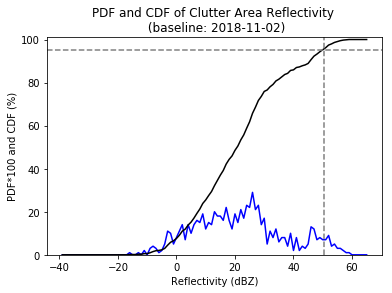

In [131]:
n_scaled = n
plt.plot(bins[1:],n_scaled,color='b')
plt.plot(bins[1:],p_mean,color='k')
plt.axhline(95,linestyle='--',color='grey')
plt.axvline(dbz95_mean,linestyle='--',color='grey')
plt.ylim(0,101)
plt.ylabel('PDF*100 and CDF (%)')
plt.xlabel('Reflectivity (dBZ)')
plt.title('PDF and CDF of Clutter Area Reflectivity \n (baseline: 2018-11-02)')
plt.show()


In [132]:
from netCDF4 import Dataset
dataset = Dataset('/home/hunzinger/data/rca_cluttermap_baseline_20181102.nc',
                  'w',format='NETCDF4_CLASSIC')
azi = dataset.createDimension('azi', 360)
rang = dataset.createDimension('rang', 6)
value = dataset.createDimension('value',1)

PCT_ON_50 = dataset.createVariable('Flagged clutter grid gates', np.float64, ('azi','rang'))
DBZ95_BASE = dataset.createVariable('Baseline 95th reflectivity', np.float64, ('value',))
DBZ95_BASECAR = dataset.createVariable('Baseline 95th reflectivity CAR', np.float64, ('value',))

PCT_ON_50[:,:] = PCT_on_50
DBZ95_BASE[:] = dbz95_baseline_mean
DBZ95_BASECAR[:] = dbz95_baseline_meanCAR

dataset.close()